# Generating animated time series using `xr_animation`

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
Animations can be a powerful method for visualising change in the landscape across time using satellite imagery. Satellite data from Digital Earth Africa is an ideal subject for animations as it has been georeferenced, processed to analysis-ready surface reflectance, and stacked into a spatio-temporal 'data cube', allowing landscape conditions to be extracted and  visualised consistently across time.

Using the DE Africa functions in `Scripts/deafrica_plotting`, which are based on `matplotlib.animation` and `xarray`, we can take a time series of Digital Earth Africa satellite imagery and export a visually appealing time series animation that shows how any location in Africa has changed.

## Description
This notebook demonstrates how to:

1. Import a time series of cloud-free satellite imagery from multiple satellites (i.e. Sentinel-2A and -2B) as an xarray dataset
2. Plot the data as a three band time series animation
3. Plot the data as a one band time series animation
4. Export the resulting animations as either a GIF or MP4 file
5. Add custom vector overlays
6. Apply custom image processing functions to each animation frame

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import skimage.exposure
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd
import xarray as xr

from deafrica_tools.plotting import xr_animation, rgb
from deafrica_tools.dask import create_local_dask_cluster

In [2]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:43969' processes=1 threads=15, memory=104.37 GB>

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Animated_timeseries')

## Load satellite data from datacube
We can use the [load_ard](Using_load_ard.ipynb) function to load data from multiple satellites (i.e. Sentinel-2A and -2B), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels. 
This will allow us to create a visually appealing time series animation of observations that are not affected by cloud.

In the example below, we request that the function returns only observations which are 95% free of clouds and other poor quality pixels by specifyinge `min_gooddata=0.95`.

In [4]:
# Load available data
ds = dc.load(product='ndvi_climatology_ls',
              output_crs='epsg:6933', 
              resolution=(-1500, 1500),
             dask_chunks=dict(x=2000,y=2000)
              )

ds = ds.compute()

In [5]:
wofs = dc.load(product='wofs_ls_summary_alltime',
               measurements=['frequency'],
              like=ds.geobox,
             dask_chunks=dict(x=1000,y=1000)
              ).frequency.squeeze()

In [6]:
wofs = wofs > 0.5
wofs = wofs.compute()

In [7]:
ds_mean = ds[['mean_jan', 'mean_feb', 'mean_mar', 'mean_apr', 'mean_may', 'mean_jun',
         'mean_jul', 'mean_aug', 'mean_sep','mean_oct','mean_nov', 'mean_dec']]


In [8]:
ds_std = ds[['stddev_jan', 'stddev_feb', 'stddev_mar', 'stddev_apr', 'stddev_may', 'stddev_jun',
         'stddev_jul', 'stddev_aug', 'stddev_sep','stddev_oct','stddev_nov', 'stddev_dec']]

In [9]:
ds_count = ds[['count_jan', 'count_feb', 'count_mar', 'count_apr', 'count_may', 'count_jun',
         'count_jul', 'count_aug', 'count_sep','count_oct','count_nov', 'count_dec']]

In [10]:
jan = ds_mean.mean_jan
feb = ds_mean.mean_feb
mar = ds_mean.mean_mar
apr = ds_mean.mean_apr
may = ds_mean.mean_may
jun = ds_mean.mean_jun
jul = ds_mean.mean_jul
aug = ds_mean.mean_aug
sep = ds_mean.mean_sep
oct_ = ds_mean.mean_oct
nov = ds_mean.mean_nov
dec = ds_mean.mean_dec

jan_s = ds_std.stddev_jan
feb_s = ds_std.stddev_feb
mar_s = ds_std.stddev_mar
apr_s = ds_std.stddev_apr
may_s = ds_std.stddev_may
jun_s = ds_std.stddev_jun
jul_s = ds_std.stddev_jul
aug_s = ds_std.stddev_aug
sep_s = ds_std.stddev_sep
oct_s = ds_std.stddev_oct
nov_s = ds_std.stddev_nov
dec_s = ds_std.stddev_dec

jan_c = ds_count.count_jan
feb_c = ds_count.count_feb
mar_c = ds_count.count_mar
apr_c = ds_count.count_apr
may_c = ds_count.count_may
jun_c = ds_count.count_jun
jul_c = ds_count.count_jul
aug_c = ds_count.count_aug
sep_c = ds_count.count_sep
oct_c = ds_count.count_oct
nov_c = ds_count.count_nov
dec_c = ds_count.count_dec

In [11]:
jan['time'] = pd.date_range(np.datetime64('2002-01-01'), periods=1)
feb['time'] = pd.date_range(np.datetime64('2002-02-01'), periods=1)
mar['time'] = pd.date_range(np.datetime64('2002-03-01'), periods=1)
apr['time'] = pd.date_range(np.datetime64('2002-04-01'), periods=1)
may['time'] = pd.date_range(np.datetime64('2002-05-01'), periods=1)
jun['time'] = pd.date_range(np.datetime64('2002-06-01'), periods=1)
jul['time'] = pd.date_range(np.datetime64('2002-07-01'), periods=1)
aug['time'] = pd.date_range(np.datetime64('2002-08-01'), periods=1)
sep['time'] = pd.date_range(np.datetime64('2002-09-01'), periods=1)
oct_['time'] = pd.date_range(np.datetime64('2002-10-01'), periods=1)
nov['time'] = pd.date_range(np.datetime64('2002-11-01'), periods=1)
dec['time'] = pd.date_range(np.datetime64('2002-12-01'), periods=1)

jan_s['time'] = pd.date_range(np.datetime64('2002-01-01'), periods=1)
feb_s['time'] = pd.date_range(np.datetime64('2002-02-01'), periods=1)
mar_s['time'] = pd.date_range(np.datetime64('2002-03-01'), periods=1)
apr_s['time'] = pd.date_range(np.datetime64('2002-04-01'), periods=1)
may_s['time'] = pd.date_range(np.datetime64('2002-05-01'), periods=1)
jun_s['time'] = pd.date_range(np.datetime64('2002-06-01'), periods=1)
jul_s['time'] = pd.date_range(np.datetime64('2002-07-01'), periods=1)
aug_s['time'] = pd.date_range(np.datetime64('2002-08-01'), periods=1)
sep_s['time'] = pd.date_range(np.datetime64('2002-09-01'), periods=1)
oct_s['time'] = pd.date_range(np.datetime64('2002-10-01'), periods=1)
nov_s['time'] = pd.date_range(np.datetime64('2002-11-01'), periods=1)
dec_s['time'] = pd.date_range(np.datetime64('2002-12-01'), periods=1)

jan_c['time'] = pd.date_range(np.datetime64('2002-01-01'), periods=1)
feb_c['time'] = pd.date_range(np.datetime64('2002-02-01'), periods=1)
mar_c['time'] = pd.date_range(np.datetime64('2002-03-01'), periods=1)
apr_c['time'] = pd.date_range(np.datetime64('2002-04-01'), periods=1)
may_c['time'] = pd.date_range(np.datetime64('2002-05-01'), periods=1)
jun_c['time'] = pd.date_range(np.datetime64('2002-06-01'), periods=1)
jul_c['time'] = pd.date_range(np.datetime64('2002-07-01'), periods=1)
aug_c['time'] = pd.date_range(np.datetime64('2002-08-01'), periods=1)
sep_c['time'] = pd.date_range(np.datetime64('2002-09-01'), periods=1)
oct_c['time'] = pd.date_range(np.datetime64('2002-10-01'), periods=1)
nov_c['time'] = pd.date_range(np.datetime64('2002-11-01'), periods=1)
dec_c['time'] = pd.date_range(np.datetime64('2002-12-01'), periods=1)

In [12]:
ds_mean_ready = xr.concat([jan,feb,mar,apr,may,jun,jul,aug,sep,oct_,nov,dec], dim='time').rename('NDVI_Climatology')
ds_mean_ready = ds_mean_ready.to_dataset()

ds_std_ready = xr.concat([jan_s,feb_s,mar_s,apr_s,may_s,jun_s,jul_s,aug_s,sep_s,oct_s,nov_s,dec_s], dim='time').rename('NDVI_Climatology')
ds_std_ready = ds_std_ready.to_dataset()

ds_count_ready = xr.concat([jan_c,feb_c,mar_c,apr_c,may_c,jun_c,jul_c,aug_c,sep_c,oct_c,nov_c,dec_c], dim='time').rename('NDVI_Climatology')
ds_count_ready = ds_count_ready.to_dataset()

In [13]:
ds_mean_ready = ds_mean_ready.where(~wofs)
ds_std_ready = ds_std_ready.where(~wofs)
ds_count_ready = ds_count_ready.where(~wofs)

## Summaries

In [14]:
total_count = ds_count_ready.sum('time')
ds_mean = ds_mean_ready.mean('time')
ds_std = ds_std_ready.mean('time')

99th % stddev:  0.1507897675037384
Max stddev:  0.36503249406814575


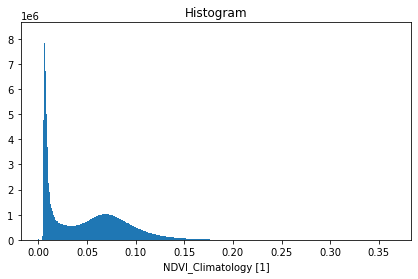

In [15]:
print('99th % stddev: ', ds_std_ready.NDVI_Climatology.quantile(0.99).values.item())
print('Max stddev: ', ds_std_ready.NDVI_Climatology.max().values.item())

ds_std_ready.NDVI_Climatology.plot.hist(bins=500, figsize=(7,4));

99th % count:  123.0
Max count:  169.0


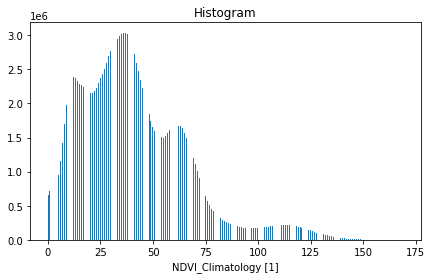

In [16]:
print('99th % count: ', ds_count_ready.where(ds_count_ready>=0).NDVI_Climatology.quantile(0.99).values.item())
print('Max count: ', ds_count_ready.where(ds_count_ready>=0).NDVI_Climatology.max().values.item())

ds_count_ready.where(ds_count_ready>=0).NDVI_Climatology.plot.hist(bins=500, figsize=(7,4));

99th % mean:  0.8303613662719727
Max mean:  0.9540817737579346


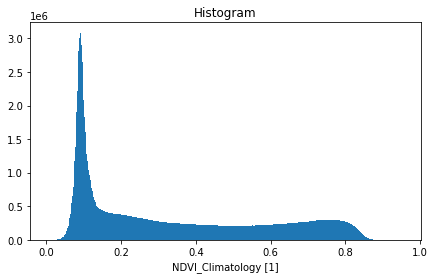

In [17]:
print('99th % mean: ', ds_mean_ready.NDVI_Climatology.quantile(0.99).values.item())
print('Max mean: ', ds_mean_ready.NDVI_Climatology.max().values.item())

ds_mean_ready.NDVI_Climatology.plot.hist(bins=500, figsize=(7,4));

Text(0.5, 1.0, 'Total Clear Observations: Landat 1984-2020')

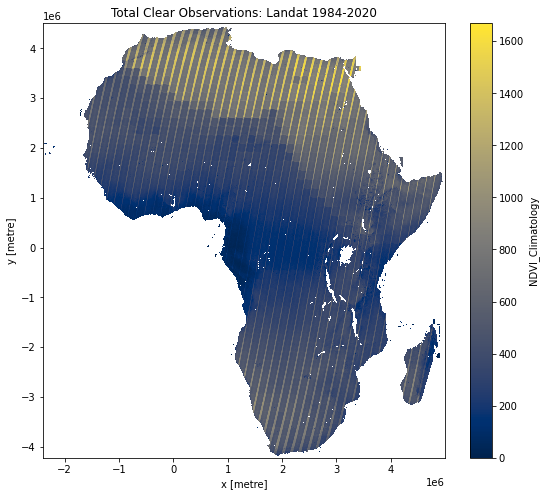

In [18]:
total_count.where(total_count >0).NDVI_Climatology.plot.imshow(figsize=(9,8), cmap='cividis', vmin = 0)
plt.title('Total Clear Observations: Landat 1984-2020')

Text(0.5, 1.0, 'Mean NDVI (1984-2020)')

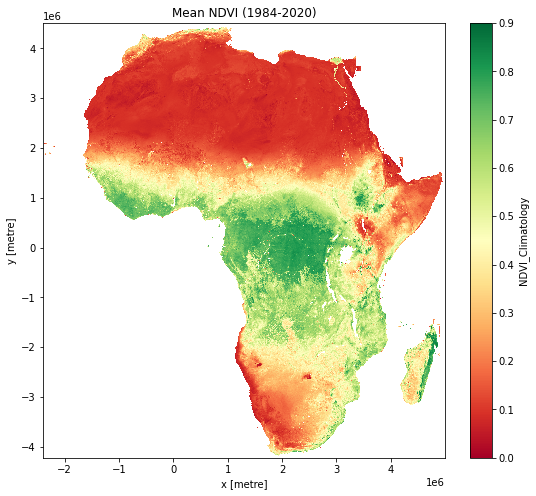

In [19]:
ds_mean.NDVI_Climatology.plot.imshow(figsize=(9,8), cmap='RdYlGn', vmin= 0.0, vmax=0.9)
plt.title('Mean NDVI (1984-2020)')

Text(0.5, 1.0, 'Mean Standard Deviation NDVI Climatology (1984-2020)')

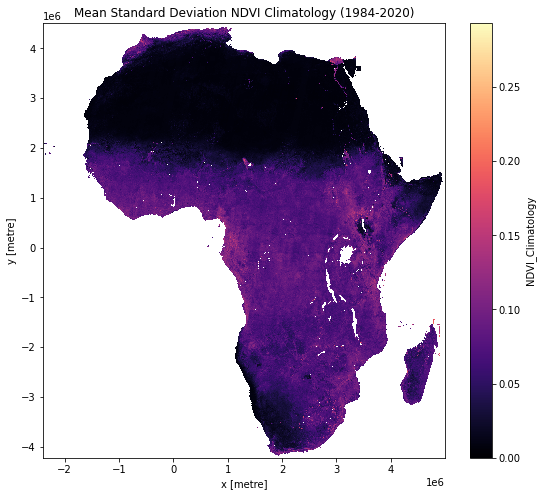

In [20]:
ds_std.NDVI_Climatology.plot.imshow(figsize=(9,8), cmap='magma',vmin=0)
plt.title('Mean Standard Deviation NDVI Climatology (1984-2020)')

## Animations

### Mean climatology

Exporting animation to results/ndvi_clim_mean.gif


  0%|          | 0/12 (0.0 seconds remaining at ? frames/s)

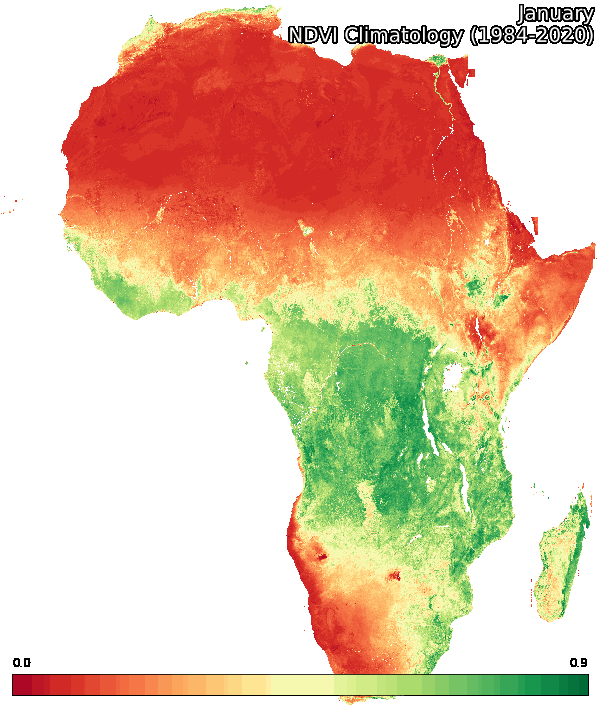

In [21]:
# Produce time series animation of NDWI:
xr_animation(ds=ds_mean_ready, 
             output_path='results/ndvi_clim_mean.gif',
             bands=['NDVI_Climatology'], 
             show_text='NDVI Climatology (1984-2020)', 
             show_date='%B',
             interval=400,
             imshow_kwargs={'cmap': 'RdYlGn', 'vmin': 0.0, 'vmax': 0.9},
             colorbar_kwargs={'colors': 'black'},
             width_pixels=600
    ) 

# Plot animated gif
plt.close()
Image(filename='results/ndvi_clim_mean.gif')

### Stddev climatology

Exporting animation to results/ndvi_clim_stddev.gif


  0%|          | 0/12 (0.0 seconds remaining at ? frames/s)

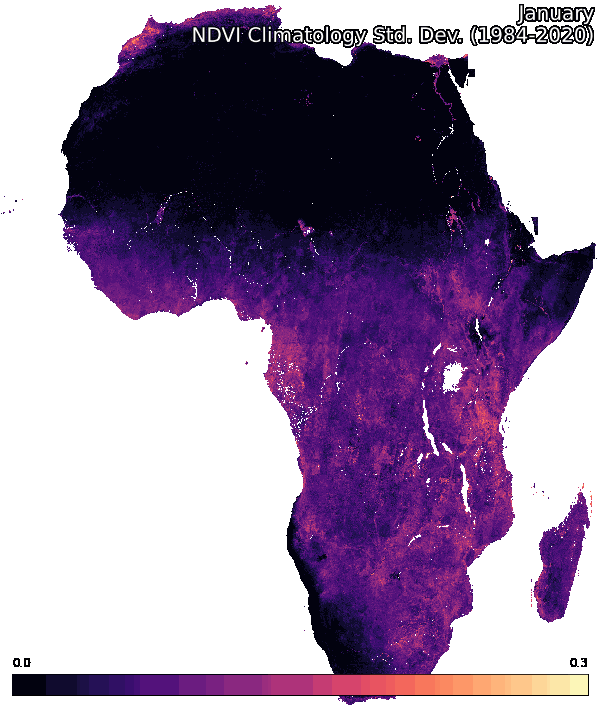

In [22]:
# Produce time series animation of NDWI:
xr_animation(ds=ds_std_ready, 
             output_path='results/ndvi_clim_stddev.gif',
             bands=['NDVI_Climatology'], 
             show_text='NDVI Climatology Std. Dev. (1984-2020)', 
             show_date='%B',
             interval=400,
             imshow_kwargs={'cmap': 'magma', 'vmin': 0.0, 'vmax': 0.30},
             colorbar_kwargs={'colors': 'black'},
             width_pixels=600
    ) 

# Plot animated gif
plt.close()
Image(filename='results/ndvi_clim_stddev.gif')

## Count

Exporting animation to results/ndvi_clim_count.gif


  0%|          | 0/12 (0.0 seconds remaining at ? frames/s)

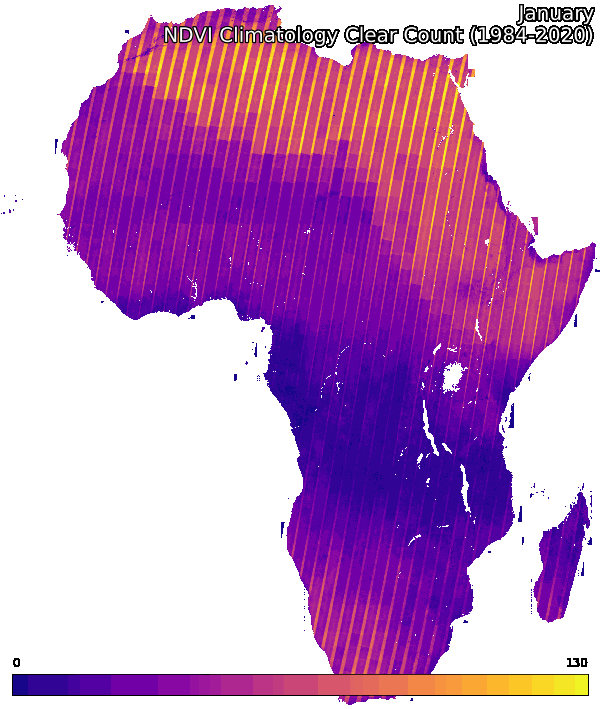

In [25]:
# Produce time series animation of NDWI:
xr_animation(ds=ds_count_ready.where(ds_count_ready!=-999), 
             output_path='results/ndvi_clim_count.gif',
             bands=['NDVI_Climatology'], 
             show_text='NDVI Climatology Clear Count (1984-2020)', 
             show_date='%B',
             interval=400,
             imshow_kwargs={'cmap': 'plasma', 'vmin': 0.0, 'vmax': 130},
             colorbar_kwargs={'colors': 'black'},
             width_pixels=600
    ) 

# Plot animated gif
plt.close()
Image(filename='results/ndvi_clim_count.gif')

## Phenology

In [ ]:
from deafrica_tools.temporal import xr_phenology, temporal_statistics

In [ ]:
east = ds_mean_ready.NDVI_Climatology.isel(y=slice(1700,2800), x=slice(3500,4600))

In [ ]:
north = ds_mean_ready.NDVI_Climatology.isel(y=slice(0,700), x=slice(500,4000))
north.isel(time=1).plot.imshow(figsize=(21,4))

In [ ]:
south = ds_mean_ready.NDVI_Climatology.isel(y=slice(5200,6000), x=slice(2500,3300))
south.isel(time=1).plot.imshow()

In [ ]:
east.isel(time=1).plot.imshow()

In [ ]:
south.mean(['x', 'y']).plot(marker='o', color='#9467bd', figsize=(11,5))


In [ ]:
east.mean(['x', 'y']).plot(marker='o', color='#9467bd', figsize=(11,5))

In [ ]:
phen = xr_phenology(south, method_eos='last', method_sos='first', verbose=False)

In [ ]:
clear = xr.ufuncs.isnan(south).sum('time') != 12

In [ ]:
phen = phen.where(clear)
# phen = phen.where(~wofs)


In [ ]:
# set up figure
fig, ax = plt.subplots(nrows=2,
                       ncols=5,
                       figsize=(20, 8),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# start of season
phen.SOS.plot.imshow(ax=ax[0, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')

phen.vSOS.plot.imshow(ax=ax[0, 1],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title('NDVI at SOS')

# peak of season
phen.POS.plot.imshow(ax=ax[0, 2],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 2].set_title('Peak of Season (DOY)')
phen.vPOS.plot.imshow(ax=ax[0, 3],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 3].set_title('NDVI at POS')

# end of season
phen.EOS.plot.imshow(ax=ax[0, 4],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 4].set_title('End of Season (DOY)')
phen.vEOS.plot.imshow(ax=ax[1, 0],
               cmap='YlGn',
               vmax=0.8,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title('NDVI at EOS')

# Length of Season
phen.LOS.plot.imshow(ax=ax[1, 1],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot.imshow(ax=ax[1, 2],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 2].set_title('Amplitude of Season')

# rate of growth
phen.ROG.plot.imshow(ax=ax[1, 3],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 3].set_title('Rate of Growth')

# rate of Sensescence
phen.ROS.plot.imshow(ax=ax[1, 4],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 4].set_title('Rate of Senescence')
plt.suptitle('Climatological Phenology')
plt.tight_layout();

## Other temporal stats

In [ ]:
# num_peaks = temporal_statistics(ds_mean_ready.NDVI_Climatology, stats='num_peaks')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')